<a href="https://colab.research.google.com/github/MadelayneLoor/ABSA/blob/main/Modelo_2_Bilstm_VF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%pip install contractions

import contractions
import gensim.downloader as api
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [2]:
# Clonar el repositorio y cargar el dataset
!git clone https://github.com/MadelayneLoor/ABSA_Tesis.git
dataset_path = "./ABSA_Tesis/datasetABSA.csv"

# Leer el dataset
df = pd.read_csv(dataset_path)

# Revisar las primeras filas
print(df.head())

# Extraer columnas necesarias
sentences = df['Comentario'].tolist()
aspects = df['Aspecto'].tolist()
polarities = df['Polaridad'].tolist()


Cloning into 'ABSA_Tesis'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 523.02 KiB | 7.69 MiB/s, done.
Resolving deltas: 100% (3/3), done.
                                          Comentario     Aspecto  Polaridad
0               la caratula sin errores ortograficos    caratula          2
1  la estructura del documento se visualiza corre...  estructura          1
2  no existen herencias la relacion entre los cas...   herencias          0
3  al existir tantos errores en el procedimientos...     errores          0
4               la caratula sin errores ortograficos    caratula          2


Funciones de entrenamiento y evaluación de modelos

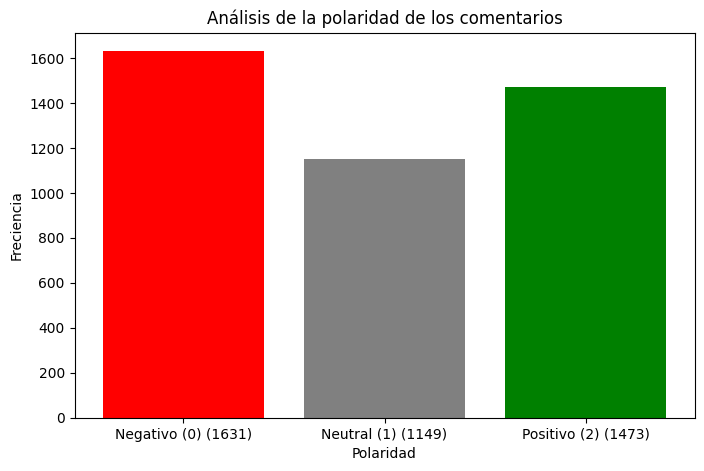

In [3]:
labels = ['Negativo (0)', 'Neutral (1)', 'Positivo (2)']
polarity_counts = df['Polaridad'].value_counts().sort_index()
polarity_counts_sorted = polarity_counts.sort_index()
adjusted_labels = [f'{label} ({count})' for label, count in zip(labels[:len(polarity_counts_sorted)], polarity_counts_sorted)]

plt.figure(figsize=(8, 5))
plt.bar(adjusted_labels, polarity_counts_sorted, color=['red', 'gray', 'green'] [:len(polarity_counts_sorted)])

plt.title('Análisis de la polaridad de los comentarios')
plt.xlabel('Polaridad')
plt.ylabel('Freciencia')
plt.show()

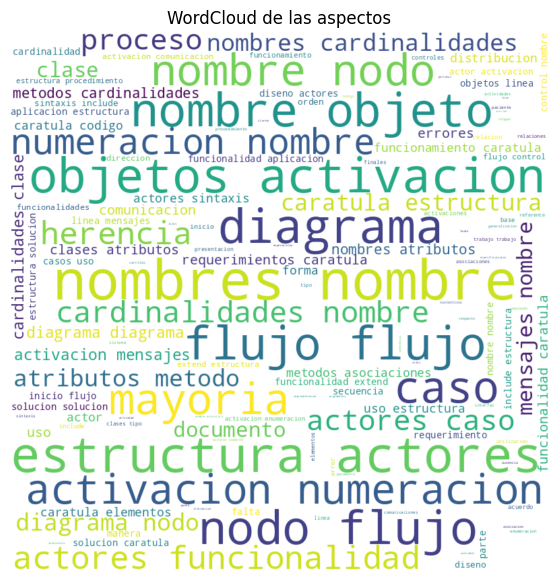

In [4]:
aspectt_text = " ".join(df['Aspecto'])
wordcloud = WordCloud(width=800, height=800, background_color="white").generate(aspectt_text)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud de las aspectos")
plt.show()

In [5]:
# Preprocesamiento adicional
def preprocess_text(text):
    text = text.lower()
    text = contractions.fix(text)
    tokens = word_tokenize(text)
    return " ".join(tokens)

sentences = [preprocess_text(sentence) for sentence in sentences]

# Construir vocabulario
word_to_ix = {"[PAD]": 0, "[UNK]": 1}
for sentence in sentences:
    tokens = word_tokenize(sentence)
    for token in tokens:
        if token not in word_to_ix:
            word_to_ix[token] = len(word_to_ix)
for aspect in aspects:
    if aspect not in word_to_ix:
        word_to_ix[aspect] = len(word_to_ix)

vocab_size = len(word_to_ix)
print(f"Tamaño del vocabulario: {vocab_size}")

# Tokenización y conversión a índices
def tokenize_and_index(data, vocab):
    tokenized_data = []
    for text in data:
        tokens = word_tokenize(text)
        indices = [vocab.get(token, vocab["[UNK]"]) for token in tokens]
        tokenized_data.append(torch.tensor(indices, dtype=torch.long))
    return tokenized_data

tokenized_sentences = tokenize_and_index(sentences, word_to_ix)
indexed_aspects = [word_to_ix.get(aspect, word_to_ix["[UNK]"]) for aspect in aspects]
label_to_ix = {0: 0, 1: 1, 2: 2}
ix_to_label = {0: "negativo", 1: "neutral", 2: "positivo"}
labels = [label_to_ix[polarity] for polarity in polarities]

# Padding
padded_sentences = pad_sequence(tokenized_sentences, batch_first=True, padding_value=word_to_ix["[PAD]"])
aspects_tensor = torch.tensor(indexed_aspects, dtype=torch.long)
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Dataset personalizado
class ABSA_Dataset(Dataset):
    def __init__(self, sentences, aspects, labels):
        self.sentences = sentences
        self.aspects = aspects
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentences[idx], self.aspects[idx], self.labels[idx]

# División de datos
train_size = int(0.7 * len(padded_sentences))
val_size = int(0.15 * len(padded_sentences))
test_size = len(padded_sentences) - train_size - val_size

train_dataset = ABSA_Dataset(padded_sentences[:train_size], aspects_tensor[:train_size], labels_tensor[:train_size])
val_dataset = ABSA_Dataset(padded_sentences[train_size:train_size+val_size], aspects_tensor[train_size:train_size+val_size], labels_tensor[train_size:train_size+val_size])
test_dataset = ABSA_Dataset(padded_sentences[train_size+val_size:], aspects_tensor[train_size+val_size:], labels_tensor[train_size+val_size:])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




Tamaño del vocabulario: 2563


In [6]:
# Modelo BiLSTM con atención
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.attention_weights = nn.Linear(hidden_dim * 2, 1, bias=False)

    def forward(self, lstm_output):
        scores = self.attention_weights(lstm_output).squeeze(2)
        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm_output).squeeze(1)
        return context, weights

class BiLSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(BiLSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True, dropout=0.3)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sentence):
        embedded = self.embedding(sentence)
        lstm_output, _ = self.lstm(embedded)
        context, weights = self.attention(lstm_output)
        output = self.fc(context)
        return output, weights

# Cargar embeddings preentrenados con gensim
print("Descargando embeddings preentrenados...")
pretrained_embeddings = api.load("glove-wiki-gigaword-300")  # Cambiar por otro modelo si es necesario
embedding_dim = pretrained_embeddings.vector_size  # Dimensión del vector

# Construir la matriz de embeddings alineada con el vocabulario
embedding_matrix = np.random.rand(len(word_to_ix), embedding_dim)  # Inicializar con valores aleatorios
print("Construyendo matriz de embeddings...")
for word, idx in word_to_ix.items():
    if word in pretrained_embeddings:
        embedding_matrix[idx] = pretrained_embeddings[word]  # Usar vector preentrenado si existe
    else:
        embedding_matrix[idx] = np.random.uniform(-0.1, 0.1, embedding_dim)  # Valores aleatorios para palabras desconocidas

print(f"Tamaño del vocabulario: {len(word_to_ix)}, Dimensión del embedding: {embedding_dim}")

# Define hidden_dim and output_dim here
hidden_dim = 128  # You can adjust this value
output_dim = 3   # Number of output classes (negativo, neutral, positivo)

# Check for GPU availability and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Optional: Print device for confirmation

# Actualizar el modelo para usar embeddings preentrenados
model = BiLSTMWithAttention(len(word_to_ix), embedding_dim, hidden_dim, output_dim, embedding_matrix)
model.to(device)

# Configuración del optimizador y función de pérdida
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.1)
criterion = nn.CrossEntropyLoss()




Descargando embeddings preentrenados...
[==================================================] 100.0% 376.1/376.1MB downloaded
Construyendo matriz de embeddings...
Tamaño del vocabulario: 2563, Dimensión del embedding: 300
Using device: cuda


In [7]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for sentences, aspects, labels in train_loader:
        sentences, labels = sentences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(sentences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    return avg_loss


# Validación
def validate_model(model, val_loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for sentences, aspects, labels in val_loader:
            sentences, labels = sentences.to(device), labels.to(device)
            outputs, _ = model(sentences)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    #print(classification_report(all_labels, all_preds, target_names=["negativo", "neutral", "positivo"]))
    avg_loss = total_loss / len(val_loader)
    return avg_loss


In [9]:
!pip install nvidia-ml-py3

  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19173 sha256=224b0d7b96abbbeccc6edc3457392a16ce19b17fd98b0f98e65018f659771fb3
  Stored in directory: /root/.cache/pip/wheels/47/50/9e/29dc79037d74c3c1bb4a8661fb608e8674b7e4260d6a3f8f51
Successfully built nvidia-ml-py3


In [10]:
import time
import torch
import psutil
import matplotlib.pyplot as plt
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo, nvmlDeviceGetUtilizationRates

# Inicializar NVML para obtener métricas de GPU
nvmlInit()
gpu_handle = nvmlDeviceGetHandleByIndex(0)

# Listas para almacenar métricas
train_losses = []
val_losses = []
cpu_usages = []
ram_usages = []
gpu_usages = []
gpu_memories = []

epochs = 15
start_time = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Capturar métricas antes de la época
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().used / (1024 ** 3)  # RAM en GB

    train_loss = train_model(model, train_loader, val_loader, optimizer, criterion)
    val_loss = validate_model(model, val_loader)

    # Capturar métricas después de la época
    cpu_end = psutil.cpu_percent(interval=None)
    ram_end = psutil.virtual_memory().used / (1024 ** 3)

    # Calcular valores absolutos
    cpu_usage = (cpu_start + cpu_end) / 2
    ram_used = ram_end  # Ahora guardamos el valor absoluto
    gpu_info = nvmlDeviceGetMemoryInfo(gpu_handle)
    gpu_utilization = nvmlDeviceGetUtilizationRates(gpu_handle)

    gpu_memory = gpu_info.used / (1024 ** 3)
    gpu_usage = gpu_utilization.gpu

    # Almacenar métricas
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    cpu_usages.append(cpu_usage)
    ram_usages.append(ram_used)
    gpu_usages.append(gpu_usage)
    gpu_memories.append(gpu_memory)

    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Métricas finales
end_time = time.time()
total_time = end_time - start_time
avg_cpu = sum(cpu_usages) / len(cpu_usages)
avg_ram = sum(ram_usages) / len(ram_usages)
avg_gpu = sum(gpu_usages) / len(gpu_usages)
avg_gpu_memory = sum(gpu_memories) / len(gpu_memories)

print("\n--- Estadísticas Finales del Entrenamiento ---")
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos ({total_time / 60:.2f} minutos)")
print(f"Uso promedio de CPU: {avg_cpu:.2f}%")
print(f"Memoria RAM promedio utilizada: {avg_ram:.2f} GB")
print(f"Uso promedio de GPU: {avg_gpu:.2f}%")
print(f"Memoria GPU promedio utilizada: {avg_gpu_memory:.2f} GB")


Epoch 1/15
Training Loss: 1.0684, Validation Loss: 1.0403
Epoch 2/15
Training Loss: 0.9794, Validation Loss: 0.9280
Epoch 3/15
Training Loss: 0.7648, Validation Loss: 0.7770
Epoch 4/15
Training Loss: 0.6510, Validation Loss: 0.7269
Epoch 5/15
Training Loss: 0.5844, Validation Loss: 0.6989
Epoch 6/15
Training Loss: 0.5527, Validation Loss: 0.6641
Epoch 7/15
Training Loss: 0.5038, Validation Loss: 0.6307
Epoch 8/15
Training Loss: 0.4609, Validation Loss: 0.6393
Epoch 9/15
Training Loss: 0.4287, Validation Loss: 0.5596
Epoch 10/15
Training Loss: 0.4188, Validation Loss: 0.5424
Epoch 11/15
Training Loss: 0.3806, Validation Loss: 0.5323
Epoch 12/15
Training Loss: 0.3601, Validation Loss: 0.5726
Epoch 13/15
Training Loss: 0.3494, Validation Loss: 0.5168
Epoch 14/15
Training Loss: 0.3182, Validation Loss: 0.5038
Epoch 15/15
Training Loss: 0.3155, Validation Loss: 0.4865

--- Estadísticas Finales del Entrenamiento ---
Tiempo total de entrenamiento: 16.12 segundos (0.27 minutos)
Uso promedio de

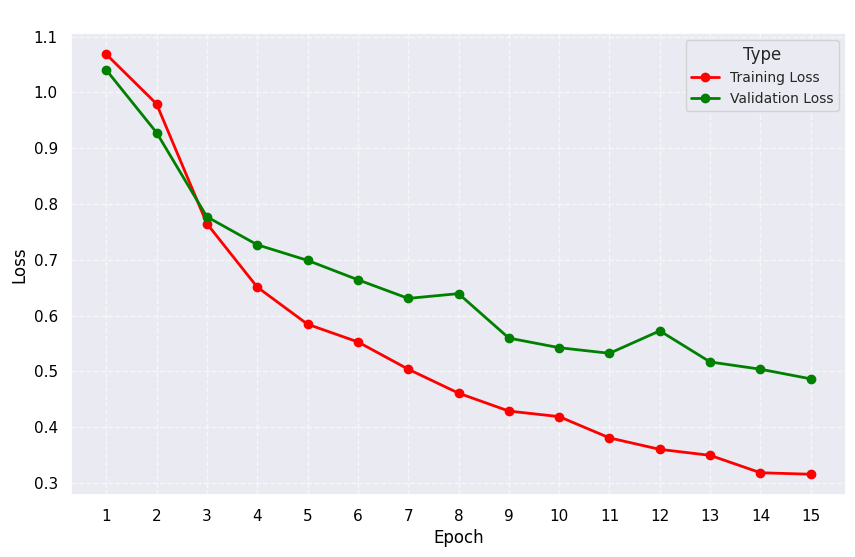

In [11]:
import seaborn as sns

# Configurar estilo de Seaborn para fondo oscuro
sns.set(style="darkgrid")

# Graficar las pérdidas con líneas y marcadores
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='red', linestyle='-', linewidth=2)
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o', color='green', linestyle='-', linewidth=2)

# Personalizar la gráfica
plt.title('Training and Validation Loss per Epoch', fontsize=14, color='white')
plt.xlabel('Epoch', fontsize=12, color='black')
plt.ylabel('Loss', fontsize=12, color='black')
plt.xticks(range(1, epochs + 1), color='black')  # Etiquetas de las épocas en el eje X
plt.yticks(color='black')  # Etiquetas del eje Y
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Type', fontsize=10, title_fontsize=12, loc='upper right')

# Cambiar fondo de la gráfica a oscuro
plt.show()


In [12]:
save_directory = "ABSA_lstm"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)
# Save the model's state dictionary
torch.save(model.state_dict(), os.path.join(save_directory, "model.pth"))

# Guardar el diccionario word_to_ix
torch.save(word_to_ix, os.path.join(save_directory, "word_to_ix.pth"))

print(f"Modelo guardados en '{save_directory}'!!!")

Modelo guardados en 'ABSA_lstm'!!!


In [13]:
def test_model(model, data_loader, device, class_names):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for sentences, aspects, labels in data_loader:  # Unpack the batch correctly
            sentences, labels = sentences.to(device), labels.to(device)
            outputs, _ = model(sentences)               # Pass sentences to the model
            preds = outputs.argmax(dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    # Assuming you have imported f1_score from sklearn.metrics
    from sklearn.metrics import f1_score # Importing f1_score
    f1 = f1_score(true_labels, predictions, average="weighted")

    # Generar informe detallado por clase
    report = classification_report(true_labels, predictions, target_names=class_names, zero_division=0)

    return accuracy, f1, report

# Lista de nombres de las clases en el mismo orden que las etiquetas
class_names = ["Negativo", "Neutral", "Positivo"]

test_accuracy, test_f1 , test_report = test_model(model, test_loader, device, class_names)
print(f"Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
print("\nDetailed Classification Report:")
print(test_report)


Test Accuracy: 0.7199, Test F1 Score: 0.7069

Detailed Classification Report:
              precision    recall  f1-score   support

    Negativo       0.64      0.79      0.71       218
     Neutral       0.84      0.44      0.58       199
    Positivo       0.76      0.90      0.82       222

    accuracy                           0.72       639
   macro avg       0.74      0.71      0.70       639
weighted avg       0.74      0.72      0.71       639



In [14]:
# Función para predecir la polaridad de un aspecto en una oración
def predict_aspect_sentiment(model, sentence, aspect, word_to_ix, ix_to_label, device, max_len=None):
    """
    Predice la polaridad de un aspecto en una oración dada.
    Args:
        model: Modelo BiLSTM con atención entrenado.
        sentence: Oración de entrada (str).
        aspect: Aspecto a analizar (str).
        word_to_ix: Diccionario de vocabulario a índices.
        ix_to_label: Diccionario de índices a etiquetas.
        device: Dispositivo (CPU o GPU).
        max_len: Longitud máxima opcional para truncar/padear la oración.
    Returns:
        Sentimiento predicho (str).
    """
    # Tokenización y conversión a índices
    tokens = word_tokenize(sentence.lower())
    sentence_indices = [word_to_ix.get(token, word_to_ix["[UNK]"]) for token in tokens]

    # Agregar el aspecto al vocabulario si no está presente
    aspect_index = word_to_ix.get(aspect.lower(), word_to_ix["[UNK]"])

    # Truncar o padear si se especifica una longitud máxima
    if max_len is not None:
        if len(sentence_indices) > max_len:
            sentence_indices = sentence_indices[:max_len]
        else:
            sentence_indices.extend([word_to_ix["[PAD]"]] * (max_len - len(sentence_indices)))

    # Convertir a tensores
    sentence_tensor = torch.tensor(sentence_indices, dtype=torch.long).unsqueeze(0).to(device)
    aspect_tensor = torch.tensor([aspect_index], dtype=torch.long).to(device)

    # Predicción
    model.eval()
    with torch.no_grad():
        outputs, _ = model(sentence_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()

    # Mapeo del índice predicho a la etiqueta correspondiente
    sentiment = ix_to_label[predicted_class]

    return sentiment


In [15]:
#!python -m spacy download es_core_news_sm
import spacy
nlp = spacy.load("es_core_news_sm")

# Función para extraer el primer aspecto de un comentario
def extract_aspect(comment):
    doc = nlp(comment)
    for token in doc:
        # Buscar el primer sustantivo
        if token.pos_ in ("NOUN"):
            return token.text
    return None  # Si no se encuentra ningún sustantivo, devolver None



OSError: [E050] Can't find model 'es_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
# Ejemplo de uso
text = "Se logra apreciar las funcionabilidades de una forma detalladas y bastante claras."
aspect = extract_aspect(text)

predicted_sentiment = predict_aspect_sentiment(
    model=model,
    sentence=text,
    aspect=aspect,
    word_to_ix=word_to_ix,
    ix_to_label=ix_to_label,
    device=device
)

print(f"Comentario: {text}")
print(f"Aspecto: {aspect}")
print(f"Sentimiento Predicho: {predicted_sentiment}")